# Setup and imports

In [1]:
# TODO Install Augmend module in venv pip install git+https://github.com/stardist/augmend.git
# https://github.com/stardist/augmend (STARDIST)
# You might need to install git in your venv using mamba install git

In [2]:
# Checking Python version
import platform
print(platform.python_version())

3.9.15


In [3]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tifffile
from pathlib import Path
from tqdm import tqdm
import czifile
from csbdeep.utils import normalize

# Input image and ground truth label loader 

In [4]:
img_directory = Path("Zeiss_Raw_Images")
label_directory = Path('Ground_truth_labels')

In [5]:
%ls {img_directory} #Check if input images are accesible

 Volume in drive C is OSDisk
 Volume Serial Number is AA79-FE69

 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL\Zeiss_Raw_Images

13.06.2023  15:49    <DIR>          .
13.06.2023  15:49    <DIR>          ..
13.06.2023  15:49       223�016�064 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
13.06.2023  15:49       394�013�760 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
13.06.2023  15:49       357�357�088 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
13.06.2023  15:49       321�772�256 1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
13.06.2023  15:49       144�293�120 1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
13.06.2023  15:49       223�987�072 1851I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
               6 File(s)  1�664�439�360 bytes

 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL


 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL


 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL


 Directory of c:\

File Not Found


In [6]:
%ls {label_directory} #Check if input images are accesible

 Volume in drive C is OSDisk
 Volume Serial Number is AA79-FE69

 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL\Ground_truth_labels

13.06.2023  16:02    <DIR>          .
13.06.2023  16:02    <DIR>          ..
13.06.2023  16:02        49�123�817 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
13.06.2023  16:02        52�471�204 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.ome.tiff
13.06.2023  16:02            49�105 1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Tumor.ome.tiff
13.06.2023  16:02        86�593�850 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
13.06.2023  16:02        86�593�847 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.ome.tiff
13.06.2023  16:02        88�217�892 1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Tumor.ome.tiff
13.06.2023  16:02        78�766�010 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Background.ome.tiff
13.06.2023  16:02        78�766�007 1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_Healthy.ome.tiff
13.06.2023  16:02     

File Not Found


In [7]:
f_images = sorted(img_directory.glob("*.czi"))
f_masks = sorted(label_directory.glob("*.tiff"))
print(f'Found {len(f_images)} images and {len(f_masks)} masks')

Found 6 images and 18 masks


In [8]:
# Input image loader (.czi files)
def read_image(fname):
    x = czifile.imread (fname)
    x = np.squeeze(x, axis=3)
    x = np.moveaxis(x, 0, -1)
    return x

imgs = tuple(normalize(read_image(f), axis=(0,1)) for f in tqdm(f_images))

100%|██████████| 6/6 [00:39<00:00,  6.64s/it]


In [9]:
# Ground truth label loader (ome.tiff files)
raw_masks = tuple(tifffile.imread(f) for f in tqdm(f_masks))

100%|██████████| 18/18 [00:01<00:00, 16.38it/s]


# Fixing overlapping pixels in between classes

In [10]:
def check_overlap(r1,r2,r3):
    '''Checks overlaps in between all 3 different class labels using a numpy logical operator
    and outputs a boolean'''
    print (f"\nBackground and Healthy share pixels: {str(np.logical_and(r1,r2).any())}")
    print (f"Background and Tumor share pixels: {str(np.logical_and(r1,r3).any())}")
    print (f"Healthy and Tumor share pixels: {str(np.logical_and(r2,r3).any())}")

masks = []
bh_shared = []
bt_shared = []
ht_shared = []

def fix_overlap(raw_masks, masks, bh_shared, bt_shared, ht_shared, f_masks):
    '''Iterates over the masks(arrays) in groups of 3 (background, healthy, tumor), finds shared positions
    among them and substitutes them for 0s in the original array, finally it appends the modified arrays
    into a masks list'''
    index = 0 #Just an index to keep track of the sample we are processing the labels for
    
    for r1, r2, r3 in zip(raw_masks[::3], raw_masks[1::3], raw_masks[2::3]):
        
        # -------------------------
        # Check if r1 and r2 share positive values at the same position (background and healthy)
        if np.logical_and(r1,r2).any():
            shared_positions = np.logical_and(r1 > 0, r2 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r1[shared_positions] = 0
            r2[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        bh_shared.append(r4)
        
        # -------------------------
        # Check if r1 and r3 share positive values at the same position (background and healthy)
        if np.logical_and(r1,r3).any():
            shared_positions = np.logical_and(r1 > 0, r3 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r1[shared_positions] = 0
            r3[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        bt_shared.append(r4)
        
        # -------------------------
        # Check if r2 and r3 share positive values at the same position (background and healthy)
        if np.logical_and(r2,r3).any():
            shared_positions = np.logical_and(r2 > 0, r3 > 0)
            # Modify positions to have a value of 0 in r1 and r2
            r2[shared_positions] = 0
            r3[shared_positions] = 0
            # Generate r4 with a value of 255 in shared positions
            r4 = np.zeros_like(r1)
            r4[shared_positions] = 255
        else:
            r4 = np.zeros_like(r1)
        # Append r4 to bh_shared
        ht_shared.append(r4)

        # --------------------------
        # Displays the results of fixing the overlapping pixel values
        print("\nFixing overlap results: \n")
        print(f_masks[index].name.replace('_Background.ome.tiff', ''))
        check_overlap(r1,r2,r3) #Checks if different class labels overlap

        # --------------------------
        # Adds the new arrays without overlapping pixels between classes into a list
        u = np.stack((r1>0, r2>0, r3>0), -1).astype(np.float32) # Create a numpy.ndarray of shape (px height, px width, 3)
        print(f"Output mask array: {u.shape} \n")
        masks.append(u) # Appends the array to the masks list
        
        index += 3 # Update the index to keep track of the sample position
                
    return masks, bh_shared, bt_shared, ht_shared
    

In [11]:
fix_overlap(raw_masks, masks, bh_shared, bt_shared, ht_shared, f_masks)
del raw_masks # Remove raw_masks variable to free up memory


Fixing overlap results: 

1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (6561, 7479, 3) 


Fixing overlap results: 

1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (9315, 9288, 3) 


Fixing overlap results: 

1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 9342, 3) 


Fixing overlap results: 

1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 8397, 3) 


Fixing overlap results: 

1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share 

In [12]:
# Checking how many pixels overlaped in between classes (bh_shared, bt_shared, ht_shared)
for i, array in enumerate(ht_shared):
    print(f"Array {i}")
    unique_values, value_counts = np.unique(array, return_counts=True)
    # Print the unique values and their counts
    for value, count in zip(unique_values, value_counts):
        print(f"Value: {value}, Count: {count}")

Array 0
Value: 0, Count: 49069719
Array 1
Value: 0, Count: 86516785
Value: 255, Count: 935
Array 2
Value: 0, Count: 78695868
Value: 255, Count: 1140
Array 3
Value: 0, Count: 70735627
Value: 255, Count: 701
Array 4
Value: 0, Count: 31741956
Array 5
Value: 0, Count: 49271652


# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


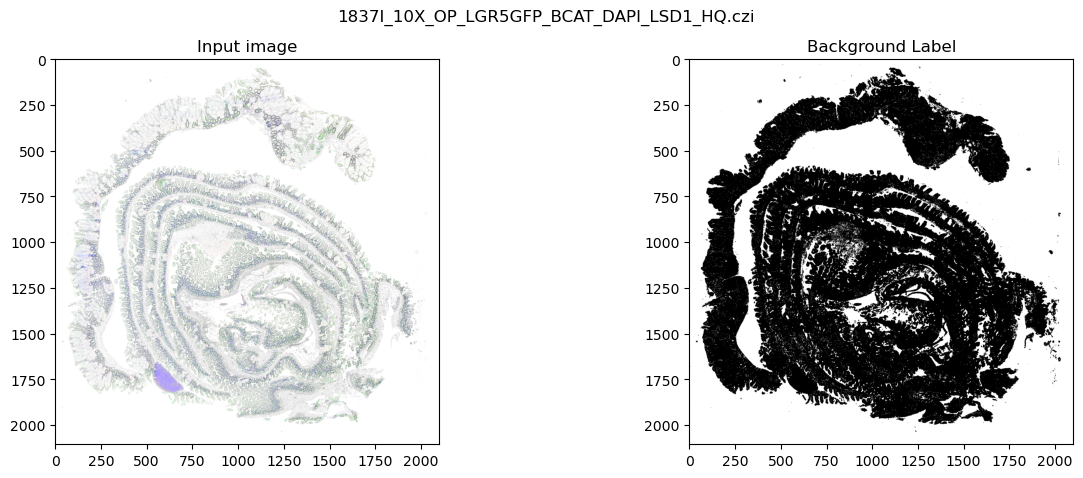

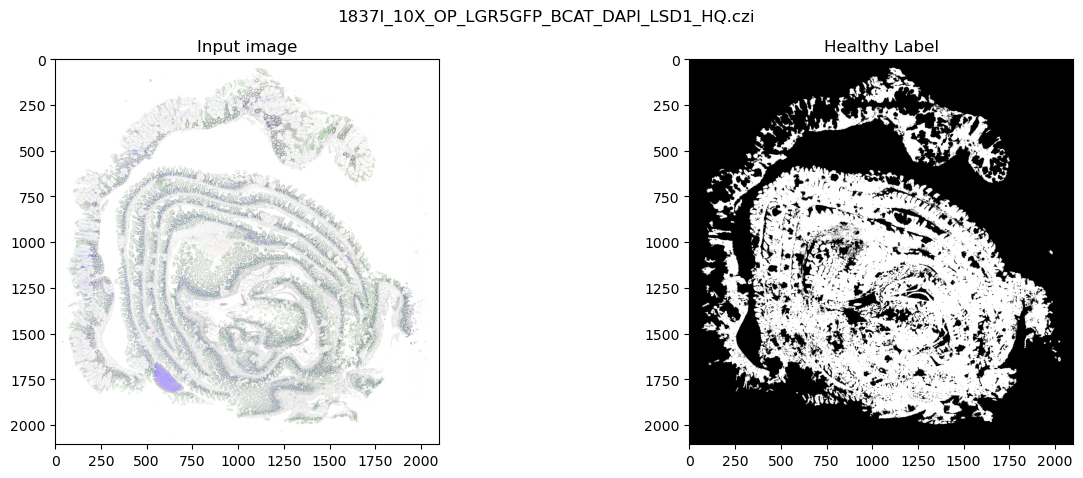

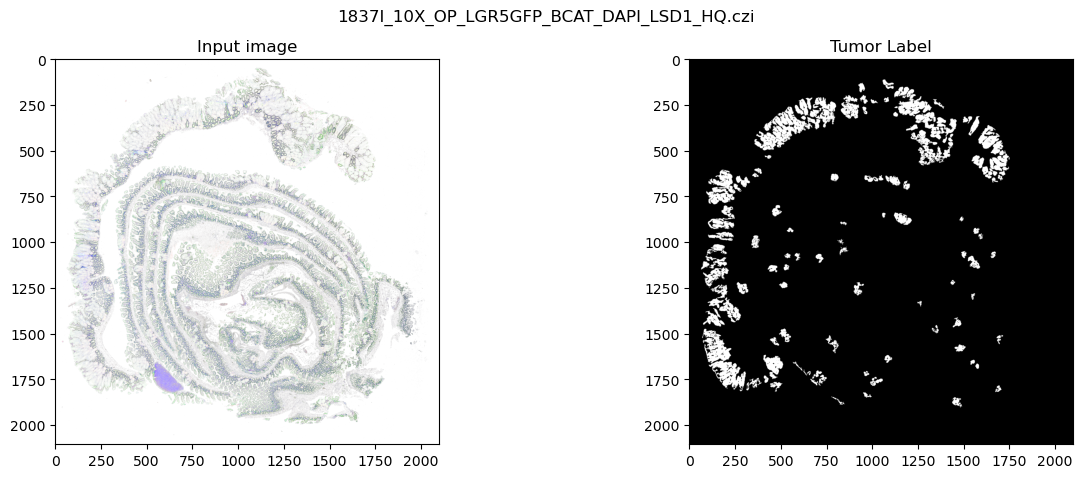

In [13]:
# Plot an example image and all of its segmentation masks
i = 3 #Define the position of the sample in the array

graph_title = ["Background", "Healthy", "Tumor"]

for mask_nr in range(3):
    fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
    a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
    a0.set_title('Input image')
    a1.imshow(masks[i][::4,::4,mask_nr], cmap='gray'); #plot every 4th pixel (subsampling)                    
    a1.set_title(f"{graph_title[mask_nr]} Label")
    fig.suptitle(f_images[i].name)
    # plt.savefig(fname=f"prediction_tiffs/{f_images[i].name}.{graph_title[mask_nr]}.png", dpi=300, format='png')
    None;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


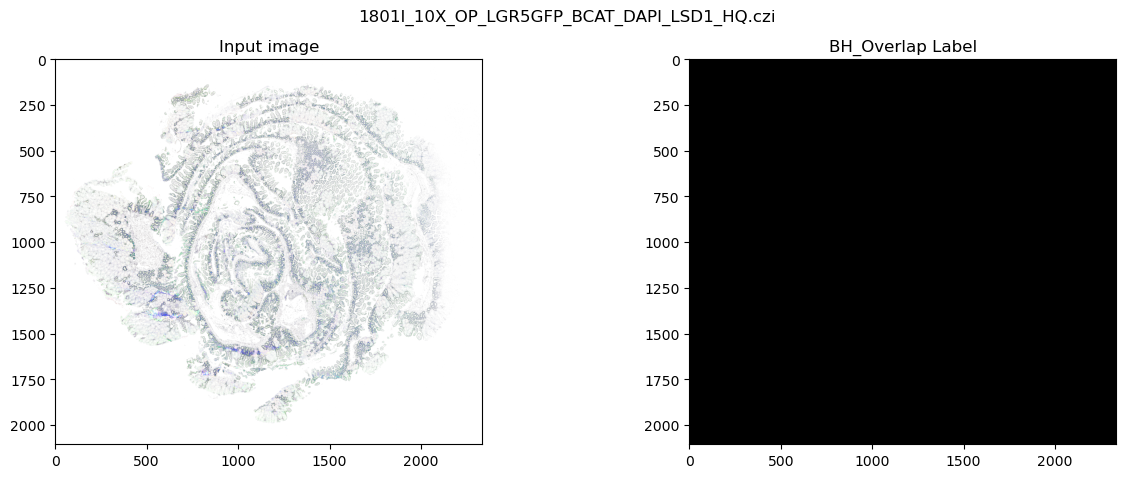

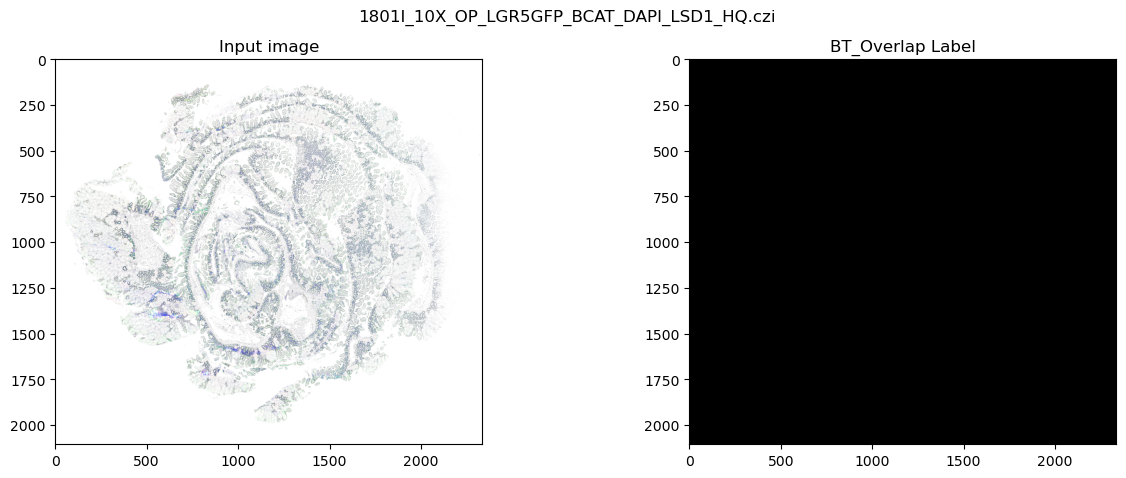

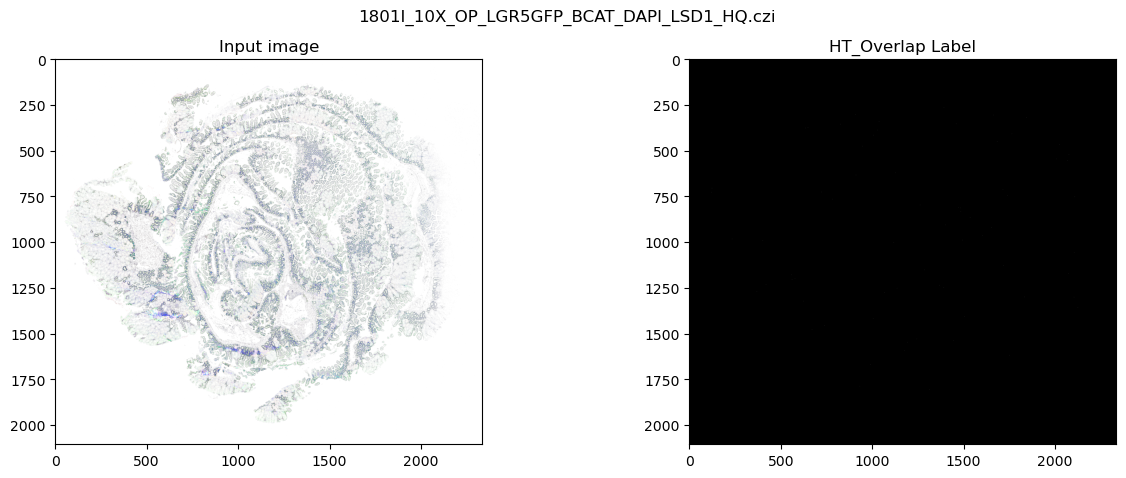

In [14]:
# Plot where labels where overlapping, hard to visualize since there were only around 0.1% overlapping
i = 2 #Define the position of the sample in the array
overlap_graph_title = ["BH_Overlap","BT_Overlap","HT_Overlap"]
overlap_list = [bh_shared, bt_shared, ht_shared]

for overlap_mask_nr in range(3):
    fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
    a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
    a0.set_title('Input image')
    a1.imshow(overlap_list[overlap_mask_nr][i][::4,::4], cmap='gray'); #plot every 4th pixel (subsampling)                    
    a1.set_title(f"{overlap_graph_title[overlap_mask_nr]} Label")
    fig.suptitle(f_images[i].name)
    # plt.savefig(fname=f"background_shared/{f_images[i].stem}.{overlap_graph_title[overlap_mask_nr]}.png", dpi=300, format='png')
    None;

# Train and validation dataset definition

In [15]:
# Using list slicing to leave 2 validation images one with and one without tumors (at index 3 and 5)
# By specifying dtype=object np allows for the creation of an ndarray that can store arrays with different shapes
imgs_array = np.asarray(imgs, dtype=object)
masks_array = np.asarray(masks, dtype=object)
train_index = [0, 1, 2, 4]
val_index = [3, 5]

X = tuple(imgs_array[train_index]) # Training inputs (features)
Y = list(masks_array[train_index]) # Training labels (target)

Xv = tuple(imgs_array[val_index]) # Validation inputs (features)
Yv = list(masks_array[val_index]) # Validation labels (target)

print(f"X: {len(X)}, Y: {len(Y)}, Xv: {len(Xv)}, Yv: {len(Yv)}")

X: 4, Y: 4, Xv: 2, Yv: 2


# Model (U-net)

In [16]:
# !rm model.py && wget https://raw.githubusercontent.com/maweigert/tutorials/main/unet_2d/model.py --no-cache -O model.py

In [17]:
import model as M

In [18]:
n_dim=2

conf = M.UNetConfig(n_dim=n_dim,
                  n_channel_in = 4,
                  n_channel_out = 3,
                  patch_size=(512,512),
                  train_batch_size=4,
                  train_class_weight = (1,1,1))

In [19]:
vars(conf)

{'n_dim': 2,
 'axes': 'XYC',
 'n_channel_in': 4,
 'n_channel_out': 3,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'softmax',
 'unet_input_shape': (None, None, 4),
 'train_loss': 'categorical_crossentropy',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'train_class_weight': (1, 1, 1),
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'patch_size': (512, 512)}

In [22]:
model = M.UNet(conf, 'model1_epoch5', basedir='models')

In [23]:
model.train(X, Y, Xv, Yv, epochs=5, steps_per_epoch=16)

Epoch 1/5
16/16 [==============================] - 53s 3s/step - loss: 0.9702 - metric_precision: 0.4414 - metric_recall: 0.0935 - metric_f1: 0.1339 - val_loss: 0.7934 - val_metric_precision: 0.8675 - val_metric_recall: 0.2269 - val_metric_f1: 0.3597 - lr: 4.0000e-04
Epoch 2/5
16/16 [==============================] - 48s 3s/step - loss: 0.5423 - metric_precision: 0.7308 - metric_recall: 0.6040 - metric_f1: 0.6226 - val_loss: 0.1106 - val_metric_precision: 0.9518 - val_metric_recall: 0.9599 - val_metric_f1: 0.9558 - lr: 4.0000e-04
Epoch 3/5
16/16 [==============================] - 52s 3s/step - loss: 0.2158 - metric_precision: 0.8703 - metric_recall: 0.8937 - metric_f1: 0.8811 - val_loss: 0.1071 - val_metric_precision: 0.9451 - val_metric_recall: 0.9588 - val_metric_f1: 0.9519 - lr: 4.0000e-04
Epoch 4/5
16/16 [==============================] - 55s 3s/step - loss: 0.3097 - metric_precision: 0.8841 - metric_recall: 0.8174 - metric_f1: 0.8480 - val_loss: 0.1217 - val_metric_precision: 0.95

# Apply the model on a test image

In [24]:
test_img_directory = Path("Zeiss_Raw_Test")
#Check if input images are accesible
%ls {test_img_directory} 
f_test_images = sorted(test_img_directory.glob("*.czi"))
print(f'found {len(f_test_images)} test images')

test_imgs = tuple(normalize(read_image(f), axis=(0,1)) for f in tqdm(f_test_images))

 Volume in drive C is OSDisk
 Volume Serial Number is AA79-FE69

 Directory of c:\Users\albertds\Python_scripts\Semantic_segmentation EMBL\Zeiss_Raw_Test

28.06.2023  14:13    <DIR>          .
28.06.2023  14:13    <DIR>          ..
14.06.2023  14:26       254�516�896 1743I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
14.06.2023  14:26       215�964�960 1800I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi
               2 File(s)    470�481�856 bytes
               2 Dir(s)  103�005�347�840 bytes free
found 2 test images


100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


In [25]:
model

UNet(model1_epoch5): XYC → XYC
├─ Directory: C:\Users\albertds\Python_scripts\Semantic_segmentation EMBL\models\model1_epoch5
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=(None, None, 4), train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0, 'verbose': True}, train_class_weight=(1, 1, 1), unet_batch_norm=False, unet_dropout=0.0, patch_size=(512, 512))

In [26]:
#TODO I might have to use a deprecated version of numpy to avoid the np.bool issue
predictions = []
for img in test_imgs:
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    predictions.append(prediction)
    print(prediction.shape)

c:\Users\albertds\mambaforge\envs\DL_keras\lib\site-packages\csbdeep\models\base_model.py:256: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +


1/1 [==============================] - 1s 760ms/step


  2%|▏         | 1/64 [00:00<?, ?it/s]

1/1 [==============================] - 0s 494ms/step


  3%|▎         | 2/64 [00:00<00:18,  3.34it/s]

1/1 [==============================] - 0s 478ms/step


  5%|▍         | 3/64 [00:01<00:24,  2.53it/s]

1/1 [==============================] - 1s 575ms/step


  6%|▋         | 4/64 [00:01<00:28,  2.08it/s]

1/1 [==============================] - 1s 632ms/step


  8%|▊         | 5/64 [00:02<00:32,  1.79it/s]

1/1 [==============================] - 0s 489ms/step


  9%|▉         | 6/64 [00:03<00:32,  1.81it/s]

1/1 [==============================] - 1s 513ms/step


 11%|█         | 7/64 [00:03<00:31,  1.79it/s]

1/1 [==============================] - 1s 537ms/step


 12%|█▎        | 8/64 [00:04<00:31,  1.76it/s]

1/1 [==============================] - 1s 545ms/step


 14%|█▍        | 9/64 [00:04<00:32,  1.67it/s]

1/1 [==============================] - 0s 466ms/step


 16%|█▌        | 10/64 [00:05<00:31,  1.73it/s]

1/1 [==============================] - 0s 417ms/step


 17%|█▋        | 11/64 [00:05<00:28,  1.83it/s]

1/1 [==============================] - 0s 437ms/step


 19%|█▉        | 12/64 [00:06<00:27,  1.89it/s]

1/1 [==============================] - 0s 451ms/step


 20%|██        | 13/64 [00:06<00:26,  1.92it/s]

1/1 [==============================] - 0s 434ms/step


 22%|██▏       | 14/64 [00:07<00:25,  1.95it/s]

1/1 [==============================] - 0s 428ms/step


 23%|██▎       | 15/64 [00:07<00:24,  1.99it/s]

1/1 [==============================] - 0s 430ms/step


 25%|██▌       | 16/64 [00:08<00:23,  2.01it/s]

1/1 [==============================] - 0s 438ms/step


 27%|██▋       | 17/64 [00:08<00:24,  1.94it/s]

1/1 [==============================] - 0s 467ms/step


 28%|██▊       | 18/64 [00:09<00:23,  1.93it/s]

1/1 [==============================] - 0s 496ms/step


 30%|██▉       | 19/64 [00:09<00:23,  1.89it/s]

1/1 [==============================] - 0s 476ms/step


 31%|███▏      | 20/64 [00:10<00:23,  1.89it/s]

1/1 [==============================] - 0s 482ms/step


 33%|███▎      | 21/64 [00:10<00:22,  1.88it/s]

1/1 [==============================] - 0s 474ms/step


 34%|███▍      | 22/64 [00:11<00:22,  1.88it/s]

1/1 [==============================] - 0s 465ms/step


 36%|███▌      | 23/64 [00:12<00:21,  1.89it/s]

1/1 [==============================] - 1s 520ms/step


 38%|███▊      | 24/64 [00:12<00:21,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 39%|███▉      | 25/64 [00:13<00:21,  1.81it/s]

1/1 [==============================] - 0s 454ms/step


 41%|████      | 26/64 [00:13<00:20,  1.86it/s]

1/1 [==============================] - 0s 465ms/step


 42%|████▏     | 27/64 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 482ms/step


 44%|████▍     | 28/64 [00:14<00:19,  1.87it/s]

1/1 [==============================] - 0s 462ms/step


 45%|████▌     | 29/64 [00:15<00:18,  1.89it/s]

1/1 [==============================] - 0s 448ms/step


 47%|████▋     | 30/64 [00:15<00:17,  1.92it/s]

1/1 [==============================] - 0s 455ms/step


 48%|████▊     | 31/64 [00:16<00:17,  1.93it/s]

1/1 [==============================] - 1s 544ms/step


 50%|█████     | 32/64 [00:16<00:17,  1.85it/s]

1/1 [==============================] - 1s 547ms/step


 52%|█████▏    | 33/64 [00:17<00:17,  1.73it/s]

1/1 [==============================] - 1s 546ms/step


 53%|█████▎    | 34/64 [00:18<00:17,  1.71it/s]

1/1 [==============================] - 0s 452ms/step


 55%|█████▍    | 35/64 [00:18<00:16,  1.78it/s]

1/1 [==============================] - 0s 462ms/step


 56%|█████▋    | 36/64 [00:19<00:15,  1.82it/s]

1/1 [==============================] - 0s 482ms/step


 58%|█████▊    | 37/64 [00:19<00:14,  1.84it/s]

1/1 [==============================] - 0s 464ms/step


 59%|█████▉    | 38/64 [00:20<00:13,  1.87it/s]

1/1 [==============================] - 0s 453ms/step


 61%|██████    | 39/64 [00:20<00:13,  1.90it/s]

1/1 [==============================] - 0s 463ms/step


 62%|██████▎   | 40/64 [00:21<00:12,  1.90it/s]

1/1 [==============================] - 0s 461ms/step


 64%|██████▍   | 41/64 [00:21<00:12,  1.84it/s]

1/1 [==============================] - 0s 481ms/step


 66%|██████▌   | 42/64 [00:22<00:11,  1.84it/s]

1/1 [==============================] - 0s 440ms/step


 67%|██████▋   | 43/64 [00:22<00:11,  1.89it/s]

1/1 [==============================] - 1s 519ms/step


 69%|██████▉   | 44/64 [00:23<00:10,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 70%|███████   | 45/64 [00:23<00:10,  1.87it/s]

1/1 [==============================] - 0s 486ms/step


 72%|███████▏  | 46/64 [00:24<00:09,  1.86it/s]

1/1 [==============================] - 1s 501ms/step


 73%|███████▎  | 47/64 [00:25<00:09,  1.84it/s]

1/1 [==============================] - 0s 485ms/step


 75%|███████▌  | 48/64 [00:25<00:08,  1.84it/s]

1/1 [==============================] - 0s 447ms/step


 77%|███████▋  | 49/64 [00:26<00:08,  1.82it/s]

1/1 [==============================] - 0s 472ms/step


 78%|███████▊  | 50/64 [00:26<00:07,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 80%|███████▉  | 51/64 [00:27<00:07,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 81%|████████▏ | 52/64 [00:27<00:06,  1.89it/s]

1/1 [==============================] - 0s 455ms/step


 83%|████████▎ | 53/64 [00:28<00:05,  1.91it/s]

1/1 [==============================] - 0s 455ms/step


 84%|████████▍ | 54/64 [00:28<00:05,  1.93it/s]

1/1 [==============================] - 0s 474ms/step


 86%|████████▌ | 55/64 [00:29<00:04,  1.92it/s]

1/1 [==============================] - 0s 470ms/step


 88%|████████▊ | 56/64 [00:29<00:04,  1.91it/s]

1/1 [==============================] - 0s 436ms/step


 89%|████████▉ | 57/64 [00:30<00:03,  1.87it/s]

1/1 [==============================] - 0s 481ms/step


 91%|█████████ | 58/64 [00:30<00:03,  1.87it/s]

1/1 [==============================] - 0s 496ms/step


 92%|█████████▏| 59/64 [00:31<00:02,  1.86it/s]

1/1 [==============================] - 0s 496ms/step


 94%|█████████▍| 60/64 [00:31<00:02,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 95%|█████████▌| 61/64 [00:32<00:01,  1.87it/s]

1/1 [==============================] - 1s 511ms/step


 97%|█████████▋| 62/64 [00:33<00:01,  1.84it/s]

1/1 [==============================] - 0s 482ms/step


 98%|█████████▊| 63/64 [00:33<00:00,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


100%|██████████| 64/64 [00:34<00:00,  1.87it/s]

(7479, 7479, 3)


1/1 [==============================] - 1s 583ms/step


  2%|▏         | 1/64 [00:00<?, ?it/s]

1/1 [==============================] - 1s 559ms/step


  3%|▎         | 2/64 [00:00<00:18,  3.27it/s]

1/1 [==============================] - 0s 426ms/step


  5%|▍         | 3/64 [00:01<00:23,  2.63it/s]

1/1 [==============================] - 0s 499ms/step


  6%|▋         | 4/64 [00:01<00:26,  2.25it/s]

1/1 [==============================] - 0s 483ms/step


  8%|▊         | 5/64 [00:02<00:28,  2.10it/s]

1/1 [==============================] - 0s 473ms/step


  9%|▉         | 6/64 [00:02<00:33,  1.76it/s]

1/1 [==============================] - 0s 476ms/step


 11%|█         | 7/64 [00:03<00:31,  1.79it/s]

1/1 [==============================] - 1s 596ms/step


 12%|█▎        | 8/64 [00:04<00:32,  1.71it/s]

1/1 [==============================] - 0s 446ms/step


 14%|█▍        | 9/64 [00:04<00:31,  1.73it/s]

1/1 [==============================] - 0s 436ms/step


 16%|█▌        | 10/64 [00:05<00:29,  1.82it/s]

1/1 [==============================] - 0s 391ms/step


 17%|█▋        | 11/64 [00:05<00:27,  1.93it/s]

1/1 [==============================] - 0s 409ms/step


 19%|█▉        | 12/64 [00:06<00:25,  2.00it/s]

1/1 [==============================] - 0s 415ms/step


 20%|██        | 13/64 [00:06<00:24,  2.04it/s]

1/1 [==============================] - 0s 444ms/step


 22%|██▏       | 14/64 [00:07<00:24,  2.03it/s]

1/1 [==============================] - 0s 449ms/step


 23%|██▎       | 15/64 [00:07<00:24,  2.02it/s]

1/1 [==============================] - 0s 496ms/step


 25%|██▌       | 16/64 [00:08<00:24,  1.96it/s]

1/1 [==============================] - 0s 411ms/step


 27%|██▋       | 17/64 [00:08<00:24,  1.93it/s]

1/1 [==============================] - 0s 430ms/step


 28%|██▊       | 18/64 [00:09<00:23,  1.97it/s]

1/1 [==============================] - 0s 434ms/step


 30%|██▉       | 19/64 [00:09<00:22,  1.99it/s]

1/1 [==============================] - 0s 448ms/step


 31%|███▏      | 20/64 [00:10<00:22,  1.99it/s]

1/1 [==============================] - 0s 417ms/step


 33%|███▎      | 21/64 [00:10<00:21,  2.03it/s]

1/1 [==============================] - 0s 417ms/step


 34%|███▍      | 22/64 [00:11<00:20,  2.06it/s]

1/1 [==============================] - 0s 429ms/step


 36%|███▌      | 23/64 [00:11<00:19,  2.07it/s]

1/1 [==============================] - 0s 432ms/step


 38%|███▊      | 24/64 [00:12<00:19,  2.07it/s]

1/1 [==============================] - 0s 437ms/step


 39%|███▉      | 25/64 [00:12<00:19,  1.97it/s]

1/1 [==============================] - 0s 429ms/step


 41%|████      | 26/64 [00:13<00:18,  2.00it/s]

1/1 [==============================] - 0s 422ms/step


 42%|████▏     | 27/64 [00:13<00:18,  2.03it/s]

1/1 [==============================] - 0s 433ms/step


 44%|████▍     | 28/64 [00:14<00:17,  2.04it/s]

1/1 [==============================] - 0s 407ms/step


 45%|████▌     | 29/64 [00:14<00:16,  2.08it/s]

1/1 [==============================] - 0s 458ms/step


 47%|████▋     | 30/64 [00:14<00:16,  2.04it/s]

1/1 [==============================] - 0s 419ms/step


 48%|████▊     | 31/64 [00:15<00:15,  2.07it/s]

1/1 [==============================] - 0s 430ms/step


 50%|█████     | 32/64 [00:15<00:15,  2.07it/s]

1/1 [==============================] - 0s 424ms/step


 52%|█████▏    | 33/64 [00:16<00:15,  2.00it/s]

1/1 [==============================] - 0s 450ms/step


 53%|█████▎    | 34/64 [00:16<00:15,  1.99it/s]

1/1 [==============================] - 0s 435ms/step


 55%|█████▍    | 35/64 [00:17<00:14,  2.01it/s]

1/1 [==============================] - 0s 438ms/step


 56%|█████▋    | 36/64 [00:17<00:13,  2.02it/s]

1/1 [==============================] - 0s 418ms/step


 58%|█████▊    | 37/64 [00:18<00:13,  2.05it/s]

1/1 [==============================] - 0s 427ms/step


 59%|█████▉    | 38/64 [00:18<00:12,  2.06it/s]

1/1 [==============================] - 1s 554ms/step


 61%|██████    | 39/64 [00:19<00:13,  1.91it/s]

1/1 [==============================] - 0s 483ms/step


 62%|██████▎   | 40/64 [00:20<00:12,  1.90it/s]

1/1 [==============================] - 0s 452ms/step


 64%|██████▍   | 41/64 [00:20<00:12,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 66%|██████▌   | 42/64 [00:21<00:11,  1.88it/s]

1/1 [==============================] - 0s 464ms/step


 67%|██████▋   | 43/64 [00:21<00:11,  1.88it/s]

1/1 [==============================] - 0s 425ms/step


 69%|██████▉   | 44/64 [00:22<00:10,  1.94it/s]

1/1 [==============================] - 0s 403ms/step


 70%|███████   | 45/64 [00:22<00:09,  2.01it/s]

1/1 [==============================] - 0s 425ms/step


 72%|███████▏  | 46/64 [00:23<00:08,  2.03it/s]

1/1 [==============================] - 0s 405ms/step


 73%|███████▎  | 47/64 [00:23<00:08,  2.08it/s]

1/1 [==============================] - 0s 406ms/step


 75%|███████▌  | 48/64 [00:23<00:07,  2.11it/s]

1/1 [==============================] - 0s 405ms/step


 77%|███████▋  | 49/64 [00:24<00:07,  2.03it/s]

1/1 [==============================] - 0s 430ms/step


 78%|███████▊  | 50/64 [00:25<00:06,  2.05it/s]

1/1 [==============================] - 0s 413ms/step


 80%|███████▉  | 51/64 [00:25<00:06,  2.07it/s]

1/1 [==============================] - 0s 431ms/step


 81%|████████▏ | 52/64 [00:25<00:05,  2.07it/s]

1/1 [==============================] - 0s 418ms/step


 83%|████████▎ | 53/64 [00:26<00:05,  2.09it/s]

1/1 [==============================] - 0s 418ms/step


 84%|████████▍ | 54/64 [00:26<00:04,  2.10it/s]

1/1 [==============================] - 0s 401ms/step


 86%|████████▌ | 55/64 [00:27<00:04,  2.13it/s]

1/1 [==============================] - 0s 431ms/step


 88%|████████▊ | 56/64 [00:27<00:03,  2.11it/s]

1/1 [==============================] - 0s 427ms/step


 89%|████████▉ | 57/64 [00:28<00:03,  2.02it/s]

1/1 [==============================] - 0s 434ms/step


 91%|█████████ | 58/64 [00:28<00:02,  2.03it/s]

1/1 [==============================] - 0s 416ms/step


 92%|█████████▏| 59/64 [00:29<00:02,  2.06it/s]

1/1 [==============================] - 0s 455ms/step


 94%|█████████▍| 60/64 [00:29<00:01,  2.03it/s]

1/1 [==============================] - 0s 426ms/step


 95%|█████████▌| 61/64 [00:30<00:01,  2.05it/s]

1/1 [==============================] - 0s 408ms/step


 97%|█████████▋| 62/64 [00:30<00:00,  2.08it/s]

1/1 [==============================] - 0s 416ms/step


 98%|█████████▊| 63/64 [00:31<00:00,  2.10it/s]

1/1 [==============================] - 0s 421ms/step


100%|██████████| 64/64 [00:31<00:00,  2.01it/s]

(5670, 8397, 3)


In [27]:
len(predictions)

2

0it [00:00, ?it/s]

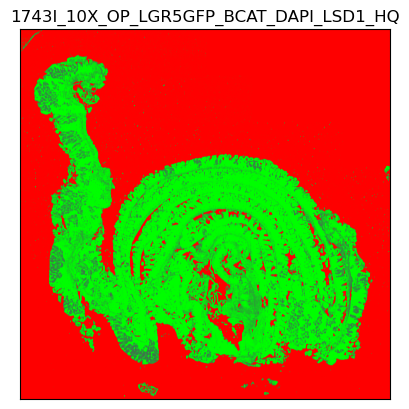

1it [00:04,  4.28s/it]

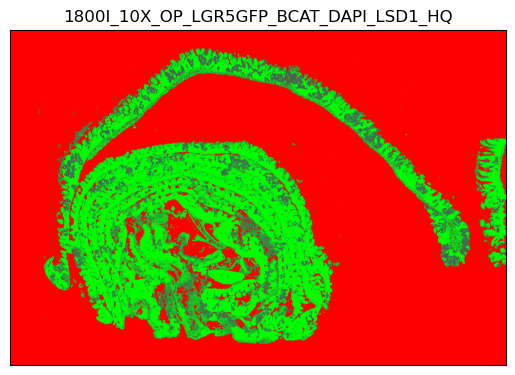

2it [00:08,  4.19s/it]


In [36]:
for i, img in tqdm(enumerate(predictions)):
    plt.imshow(img)
    # Remove the x-axis ticks and numbers
    plt.xticks([])
    # Remove the y-axis ticks and numbers
    plt.yticks([])
    plt.title(f_test_images[i].stem)
    plt.show()